# 🤖 BERT 기반 문단별 AI/Human 분류 및 문서 라벨 예측 시스템 (Colab)

## 📋 개요

이 노트북은 다음의 작업을 수행합니다:
1. **문단별 분류 모델 학습**: Synthetic pairs 데이터로 BERT 기반 문단 분류 모델 학습
2. **문단별 점수 예측**: 원본 문서의 각 문단에 대해 AI 확률 점수 계산
3. **문서별 집계**: 문단 점수를 집계하여 문서 전체 라벨 예측
4. **반복 학습**: Human 예측 문서의 문단 점수를 0으로 조정하여 재학습
5. **시각화 및 트래킹**: 모든 과정의 시각화 및 성능 추적

---
**Google Colab 전용 버전**
- Google Drive 마운트 필요
- 데이터 경로: `/content/drive/MyDrive/멋사_프로젝트_01/`

## 🔧 Colab 환경 설정

In [3]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive 마운트 완료!")

Mounted at /content/drive
✅ Google Drive 마운트 완료!


In [4]:
# GPU 확인
import torch
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

CUDA 사용 가능: True
GPU 이름: Tesla T4
GPU 메모리: 14.74 GB


In [ ]:
# 필요한 라이브러리 설치 (Colab에 없는 경우)
!pip install -q transformers datasets

## 📦 라이브러리 Import

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
from datetime import datetime

# 한글 폰트 설정 (Colab)
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  사용 디바이스: {device}")

Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
🖥️  사용 디바이스: cuda


## 📁 경로 설정

In [6]:
# Google Drive 경로 설정
BASE_PATH = '/content/drive/MyDrive/멋사_프로젝트_01/'
SYNTHETIC_DATA_PATH = os.path.join(BASE_PATH, 'gpt_oss_synthetic_pairs_cleaned.csv')
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'test.csv')
CHECKPOINT_DIR = os.path.join(BASE_PATH, 'checkpoints')

# 체크포인트 디렉토리 생성
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# 파일 존재 확인
print("📂 파일 확인:")
print(f"  Synthetic pairs: {os.path.exists(SYNTHETIC_DATA_PATH)} - {SYNTHETIC_DATA_PATH}")
print(f"  Train data: {os.path.exists(TRAIN_DATA_PATH)} - {TRAIN_DATA_PATH}")
print(f"  Test data: {os.path.exists(TEST_DATA_PATH)} - {TEST_DATA_PATH}")
print(f"  Checkpoint dir: {CHECKPOINT_DIR}")

📂 파일 확인:
  Synthetic pairs: True - /content/drive/MyDrive/멋사_프로젝트_01/gpt_oss_synthetic_pairs_cleaned.csv
  Train data: True - /content/drive/MyDrive/멋사_프로젝트_01/train.csv
  Test data: True - /content/drive/MyDrive/멋사_프로젝트_01/test.csv
  Checkpoint dir: /content/drive/MyDrive/멋사_프로젝트_01/checkpoints


## 📊 모델 아키텍처 상세

### 전체 구조
```
입력 문단 텍스트 (str)
    ↓
BERT Tokenizer (WordPiece)
  • max_length: 512
  • padding: 'max_length'
  • truncation: True
    ↓
Token IDs: [batch_size, 512]
Attention Mask: [batch_size, 512]
    ↓
BERT Encoder (klue/bert-base)
  • 12 Transformer Layers
  • Hidden Size: 768
  • Attention Heads: 12
  • Parameters: ~110M
    ↓
[CLS] Token Embedding: [batch_size, 768]
    ↓
Dropout (p=0.1): [batch_size, 768]
    ↓
Linear (768 → 2): [batch_size, 2]
    ↓
Softmax: [batch_size, 2]
    ↓
출력: [Human 확률, AI 확률]
```

### 입력/출력 차원
- **입력**: 문단 텍스트 (가변 길이)
- **Tokenizer 출력**: `[batch_size, 512]`
- **BERT 출력**: `[batch_size, 512, 768]` → `[CLS]` 토큰만 사용 → `[batch_size, 768]`
- **분류기 출력**: `[batch_size, 2]` (로짓) → Softmax → 확률값

## 1️⃣ 데이터 로드 및 전처리

### 데이터 구조
- **Synthetic Pairs**: `gpt_oss_synthetic_pairs_cleaned.csv`
  - Columns: `para_id, source_doc_id, para_index, source_title, human_paragraph, ai_paragraph, generation_success`
  - 각 행은 (Human 문단, AI 문단) 쌍
  - 총 1,630개 쌍

### 전처리 과정
1. Human 문단 → label=0, AI 문단 → label=1
2. 데이터 중복 제거
3. Train/Valid 분할 (8:2)

In [7]:
# Synthetic pairs 데이터 로드
df_synthetic = pd.read_csv(SYNTHETIC_DATA_PATH)

print(f"📊 Synthetic Pairs 데이터 로드 완료: {len(df_synthetic):,}개")
print(f"\n컬럼: {list(df_synthetic.columns)}")
df_synthetic.head()

📊 Synthetic Pairs 데이터 로드 완료: 1,140개

컬럼: ['para_id', 'source_doc_id', 'para_index', 'source_title', 'human_paragraph', 'ai_paragraph', 'generation_success']


,para_id,source_doc_id,para_index,source_title,human_paragraph,ai_paragraph,generation_success
0,17579,1413,0,박중빈,1891년 전라남도 영광군 길룡리에서 평범한 농민의 아들로 태어났다. 7세부터 자연...,"1891년 전라남도 영광군 길룡리에서 평범한 농가의 아들로 태어났고, 7세부터는 자...",True
1,17580,1413,1,박중빈,"이후 박중빈은 '물질이 개벽되니 정신을 개벽하자'는 표어를 주창하며, 먼저 미신타파...","이후 박중빈은 ‘물질이 개벽되니 정신을 개벽하자’는 구호를 내세우고, 미신 타파, ...",True
2,17581,1413,2,박중빈,원불교 창시자이자 초대 종법사인 소태산은 길룡리 영촌마을의 평범한 농가에서 태어났지...,원불교의 창시자이자 초대 종법사인 소태산은 길룡리 영촌마을의 평범한 농가에서 태어났...,True
3,17582,1413,3,박중빈,원불교 교전 중에 “만유가 한 체성이며 만법이 한 근원이로다. 이 가운데 생멸 없는...,"원불교가 교전 단계에 들어섰을 때, “만유는 하나의 체성이고, 만법은 하나의 근원이...",True
4,17583,1413,4,박중빈,특히 소태산 대종사는 스스로 깨닫고 나서 비로소 기존 종교들에 대한 궁금증이 생겨 ...,특히 소태산 대종사는 스스로 깨달음을 얻은 뒤 비로소 기존 종교들에 대한 호기심이 ...,True


In [8]:
# 데이터 준비: Human과 AI 문단을 각각 레이블링
# Human 문단들
human_texts = df_synthetic['human_paragraph'].tolist()
human_labels = [0] * len(human_texts)  # Human = 0

# AI 문단들
ai_texts = df_synthetic['ai_paragraph'].tolist()
ai_labels = [1] * len(ai_texts)  # AI = 1

# 결합
all_texts = human_texts + ai_texts
all_labels = human_labels + ai_labels

print(f"\n전체 데이터: {len(all_texts):,}개")
print(f"  - Human 문단: {sum([1 for l in all_labels if l == 0]):,}개")
print(f"  - AI 문단: {sum([1 for l in all_labels if l == 1]):,}개")

# Train/Valid 분할
train_texts, valid_texts, train_labels, valid_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"\n✅ 데이터 분할 완료:")
print(f"  - Train: {len(train_texts):,}개")
print(f"  - Valid: {len(valid_texts):,}개")


전체 데이터: 2,280개
  - Human 문단: 1,140개
  - AI 문단: 1,140개

✅ 데이터 분할 완료:
  - Train: 1,824개
  - Valid: 456개


## 2️⃣ Dataset 및 DataLoader 구성

### Dataset 클래스
- **입력**: 문단 텍스트 리스트, 레이블 리스트
- **Tokenization**: BERT Tokenizer 사용
- **출력**: `input_ids`, `attention_mask`, `labels`

In [9]:
# BERT Tokenizer 로드
MODEL_NAME = 'klue/bert-base'  # 또는 'beomi/kcbert-base'
MAX_LENGTH = 512

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"🔤 Tokenizer 로드 완료: {MODEL_NAME}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

🔤 Tokenizer 로드 완료: klue/bert-base


In [10]:
class ParagraphDataset(Dataset):
    """
    문단 텍스트를 입력받아 BERT 입력 형식으로 변환하는 Dataset

    입력 형식:
      - texts: List[str] - 문단 텍스트 리스트
      - labels: List[int] - 레이블 (0=Human, 1=AI)
      - tokenizer: BERT Tokenizer
      - max_length: int - 최대 토큰 길이 (기본 512)

    출력 형식:
      - input_ids: Tensor [max_length] - 토큰 ID
      - attention_mask: Tensor [max_length] - Attention Mask
      - labels: Tensor [1] - 레이블
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenization
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # [max_length]
            'attention_mask': encoding['attention_mask'].squeeze(0),  # [max_length]
            'labels': torch.tensor(label, dtype=torch.long)  # [1]
        }

# Dataset 생성
train_dataset = ParagraphDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
valid_dataset = ParagraphDataset(valid_texts, valid_labels, tokenizer, MAX_LENGTH)

print(f"✅ Dataset 생성 완료")
print(f"  - Train Dataset: {len(train_dataset):,}개")
print(f"  - Valid Dataset: {len(valid_dataset):,}개")

✅ Dataset 생성 완료
  - Train Dataset: 1,824개
  - Valid Dataset: 456개


In [11]:
# DataLoader 설정
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ DataLoader 생성 완료")
print(f"  - Train Batches: {len(train_loader):,}개")
print(f"  - Valid Batches: {len(valid_loader):,}개")

✅ DataLoader 생성 완료
  - Train Batches: 114개
  - Valid Batches: 29개


## 3️⃣ 모델 정의

### BERTParagraphClassifier

**구조**:
```python
class BERTParagraphClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2, dropout=0.1):
        # BERT 인코더: AutoModel (110M params)
        # Dropout: nn.Dropout(p=dropout)
        # Classifier: nn.Linear(768 → num_classes)
```

**Forward Pass**:
1. 입력: `input_ids` [batch, 512], `attention_mask` [batch, 512]
2. BERT 출력: `outputs.last_hidden_state` [batch, 512, 768]
3. [CLS] Token 추출: `outputs.last_hidden_state[:, 0, :]` [batch, 768]
4. Dropout 적용: [batch, 768]
5. Linear: [batch, 768] → [batch, 2]
6. 출력: logits [batch, 2]

In [12]:
class BERTParagraphClassifier(nn.Module):
    """
    BERT 기반 문단 분류 모델

    아키텍처:
      1. BERT Encoder: [batch, seq_len] → [batch, seq_len, 768]
      2. [CLS] Token 추출: [batch, 768]
      3. Dropout: [batch, 768]
      4. Linear Classifier: [batch, 768] → [batch, num_classes]

    Parameters:
      - model_name: str - BERT 모델 이름
      - num_classes: int - 분류 클래스 수 (기본 2)
      - dropout: float - Dropout 비율 (기본 0.1)
    """
    def __init__(self, model_name, num_classes=2, dropout=0.1):
        super(BERTParagraphClassifier, self).__init__()

        # BERT 인코더
        self.bert = AutoModel.from_pretrained(model_name)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # 분류기 (768 → num_classes)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass

        입력:
          - input_ids: [batch_size, max_length]
          - attention_mask: [batch_size, max_length]

        출력:
          - logits: [batch_size, num_classes]
        """
        # BERT 인코더 통과
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # [CLS] 토큰 임베딩 추출 ([batch_size, 768])
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Dropout 적용
        cls_embedding = self.dropout(cls_embedding)

        # 분류기 통과 ([batch_size, num_classes])
        logits = self.classifier(cls_embedding)

        return logits

# 모델 생성
model = BERTParagraphClassifier(MODEL_NAME, num_classes=2, dropout=0.1)
model = model.to(device)

# 모델 파라미터 수 출력
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n🤖 모델 생성 완료")
print(f"  - 총 파라미터: {total_params:,}개")
print(f"  - 학습 가능 파라미터: {trainable_params:,}개")

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]


🤖 모델 생성 완료
  - 총 파라미터: 110,618,882개
  - 학습 가능 파라미터: 110,618,882개


## 4️⃣ 학습 설정

### Optimizer & Scheduler
- **Optimizer**: Adam (lr=2e-5)
- **Scheduler**: Linear warmup + decay
- **Loss**: CrossEntropyLoss

In [13]:
# 학습 설정
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 100

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# Loss Function
criterion = nn.CrossEntropyLoss()

print(f"⚙️  학습 설정 완료")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Total Steps: {total_steps:,}")
print(f"  - Warmup Steps: {WARMUP_STEPS}")

⚙️  학습 설정 완료
  - Epochs: 3
  - Learning Rate: 2e-05
  - Total Steps: 342
  - Warmup Steps: 100


## 5️⃣ 학습 및 평가 함수

In [14]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    """
    1 Epoch 학습

    Returns:
      - avg_loss: float - 평균 손실
    """
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    """
    모델 평가

    Returns:
      - avg_loss: float - 평균 손실
      - accuracy: float - 정확도
      - f1: float - F1 Score
      - auc: float - ROC AUC
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            # 예측값 계산
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # AI 확률

    # 메트릭 계산
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)

    return avg_loss, accuracy, f1, auc, all_labels, all_preds

## 6️⃣ 모델 학습

In [15]:
# 학습 기록 저장
training_history = {
    'train_loss': [],
    'valid_loss': [],
    'valid_accuracy': [],
    'valid_f1': [],
    'valid_auc': []
}

best_f1 = 0

print("\n🚀 학습 시작...\n")
for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    # 학습
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    print(f"Train Loss: {train_loss:.4f}")

    # 평가
    valid_loss, accuracy, f1, auc, labels, preds = evaluate(model, valid_loader, criterion, device)
    print(f"Valid Loss: {valid_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")

    # 기록 저장
    training_history['train_loss'].append(train_loss)
    training_history['valid_loss'].append(valid_loss)
    training_history['valid_accuracy'].append(accuracy)
    training_history['valid_f1'].append(f1)
    training_history['valid_auc'].append(auc)

    # Best 모델 저장
    if f1 > best_f1:
        best_f1 = f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'f1': f1,
        }, f'{CHECKPOINT_DIR}/best_model.pt')
        print(f"✅ Best 모델 저장 (F1: {f1:.4f})")

print("\n🎉 학습 완료!")


🚀 학습 시작...


===== Epoch 1/3 =====


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Train Loss: 0.7167


Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Valid Loss: 0.6598
Accuracy: 0.6140
F1 Score: 0.6923
ROC AUC: 0.6832
✅ Best 모델 저장 (F1: 0.6923)

===== Epoch 2/3 =====


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Train Loss: 0.5893


Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Valid Loss: 0.6047
Accuracy: 0.6447
F1 Score: 0.6215
ROC AUC: 0.7310

===== Epoch 3/3 =====


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Train Loss: 0.4374


Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Valid Loss: 0.6173
Accuracy: 0.6776
F1 Score: 0.6969
ROC AUC: 0.7467
✅ Best 모델 저장 (F1: 0.6969)

🎉 학습 완료!


## 7️⃣ 학습 결과 시각화

/tmp/ipython-input-4033085671.py:23: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4033085671.py:23: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4033085671.py:23: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4033085671.py:23: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4033085671.py:23: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4033085671.py:23: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4033085671.py:23: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_la

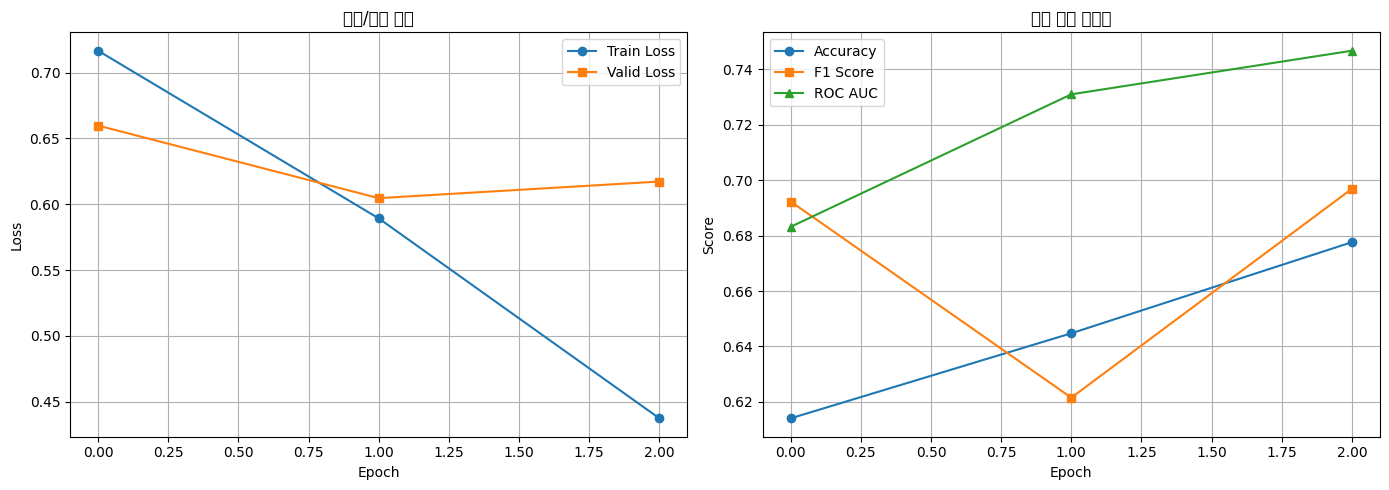

In [16]:
# Loss 그래프
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train/Valid Loss
axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['valid_loss'], label='Valid Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('학습/검증 손실')
axes[0].legend()
axes[0].grid(True)

# Metrics
axes[1].plot(training_history['valid_accuracy'], label='Accuracy', marker='o')
axes[1].plot(training_history['valid_f1'], label='F1 Score', marker='s')
axes[1].plot(training_history['valid_auc'], label='ROC AUC', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('검증 성능 메트릭')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

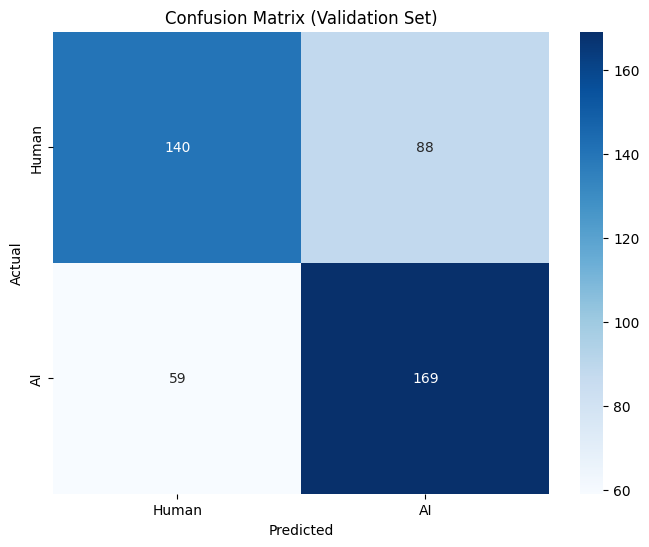

In [18]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.savefig(f'{CHECKPOINT_DIR}/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 8️⃣ 결과 저장

In [17]:
# 학습 기록 저장
with open(f'{CHECKPOINT_DIR}/training_history.json', 'w') as f:
    json.dump(training_history, f, indent=2)

print("✅ 모든 결과 저장 완료!")
print(f"📁 저장 위치: {CHECKPOINT_DIR}")
print(f"\n✨ Best F1 Score: {best_f1:.4f}")

✅ 모든 결과 저장 완료!
📁 저장 위치: /content/drive/MyDrive/멋사_프로젝트_01/checkpoints

✨ Best F1 Score: 0.6969


---

## 📝 다음 단계

이제 학습된 모델을 사용하여:
1. `train.csv` 전체 문서에 대해 문단별 점수 예측
2. 문서별 집계 및 라벨 예측
3. 반복 학습 메커니즘 적용
4. `test.csv`로 최종 예측

이 작업들은 `original_data_pipeline.ipynb`에서 계속됩니다.